Notes:

**Form of score**.  Given triple $(p_{ent}, p_{neu}, p_{con})$, do we do $p_{ent} - p_{con}$ or $log(p_{ent}/p_{con})$.  Note that using log amounts to the log-likelihood ratio of E vs C.  Assume each posterior is calibrated as:

$$
p_y(x) = Pr(Y=y|x) = \frac{Pr(x|Y=y)\pi_y}{\sum_{y'} Pr(x|Y=y')\pi_{y'}}
$$

so we form

$$
\frac{p_{ent}(x)}{p_{con}(x)} = \frac{Pr(x|Y=E)\pi_E}{Pr(x|Y=C)\pi_C}
$$

(because denominators from Bayes cancel).  If the training used balanced E/C priors then the priors also cancel, and taking logs we have

$$
\log \frac{p_E(x)}{p_C(x)} = \log \frac{Pr(x|Y=E)}{Pr(x|Y=C)} = \Lambda(x)
$$

Likelihoods multiply, so across multiple observations (sentences/clauses), the LLRs add:

$$
\Lambda(x_{1:m}) = \sum_{k=1}^m \Lambda(x_k)
$$

Note this is connected to a Bayes factor.  Given hypothesis $H$ and observation $x$, the Bayes factor is

$$
B(x) = \frac{Pr(x|H)}{Pr(x|\not H)}
$$

...

**Sensitivity of embedder.**  Similar phrases give different entailment scores ("I am willing" vs "I would be willing").  Idea: have a paraphrase set $\{H_i\}$ for each hypothesis, score each sentence/clause against entire set and average.  Possibly:

$$
\ell(c) = \log \left( \frac{1}{m} \sum_i \exp (\ell_i(c)) \right)
$$

In [1]:
import json
import sys
import os

# hack so we can import normally from other packages
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sentence_transformers import SentenceTransformer
import torch

from agent.agent import Agent
from mcts.mcts_node import ConversationState

/home/stmorse/projects/scope2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
NLI_MODEL = "MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli"

class NLIWrapper:
    def __init__(self):
        model_name = NLI_MODEL
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name)
        
        # Move model to GPU
        self.model = self.model.to(self.device)
        self.model.eval()

    def get_embed_and_prob(self, premise, hypothesis):
        inputs = self.tokenizer(premise, hypothesis, truncation=True, return_tensors="pt")
        # print(f"Token count: {inputs['input_ids'].shape[1]}")

        # tokens = self.tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
        # print(f"First: {tokens[:10]}")
        # print(f"Non-hypo last: {tokens[-20:-10]}")
        # print(f"Hypothesis: {tokens[-10:]}")

        # Move inputs to same device as model
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        # get embedding and logits
        with torch.no_grad():
            enc = self.model.deberta(**inputs)                    # base encoder
            pooled = self.model.pooler(enc.last_hidden_state)     # [1, hidden_size]
            features = self.model.dropout(pooled)                 # pre-classifier embedding
            logits = self.model.classifier(features)              # NLI logits (E/C/N)

        # features is the pair-specific embedding used for the decision
        embedding = features.squeeze(0).cpu()  # shape [hidden_size], here 1024
        probs  = logits.softmax(dim=-1).squeeze(0).cpu()

        return embedding, probs


In [44]:
scenario_name = "fender"
LEVER = 0  # which lever to use
v0 = -0.25   # valence for agent 0
v1 = 1.0   # valence for agent 1

with open(f"../scenarios/{scenario_name}.json", "r") as f:
    scenario = json.load(f)
hypothesis = scenario["base"]
levers = scenario["levers"]

valences = [v0, v1]
agents = {i: Agent(
    name=scenario["personas"]["names"][i],
    order=i,
    provider="ollama", 
    model="llama3.2:latest", 
    persona=Agent.build_persona(scenario, valences[i], i),
    forcing=False
) for i in range(2)}

# initialize embedders
nli_model = NLIWrapper()


Using device: cuda


In [10]:
eps = 0.01

for stance, phrase in scenario["personas"]["stance"].items():
    clauses = phrase.split(",")
    _, prob0 = nli_model.get_embed_and_prob(
        premise=clauses[0],
        hypothesis=hypothesis
    )
    _, probf = nli_model.get_embed_and_prob(
        premise=phrase,
        hypothesis=hypothesis
    )

    prob0 = prob0.numpy()
    probf = probf.numpy()

    print(
        f"{stance}: "
        f"  {[f"{p:.3f}" for p in prob0]} {np.log((prob0[0] + eps) / (prob0[2] + eps)):.3f}"
        f"  {[f"{p:.3f}" for p in probf]} {np.log((probf[0] + eps) / (probf[2] + eps)):.3f}")

-1.00:   ['0.000', '0.001', '0.999'] -4.605  ['0.000', '0.002', '0.998'] -4.604
-0.75:   ['0.000', '0.000', '0.999'] -4.608  ['0.000', '0.001', '0.999'] -4.607
-0.50:   ['0.000', '0.002', '0.998'] -4.591  ['0.000', '0.002', '0.998'] -4.593
-0.25:   ['0.002', '0.932', '0.066'] -1.832  ['0.003', '0.956', '0.041'] -1.380
0.00:   ['0.001', '0.256', '0.743'] -4.217  ['0.003', '0.983', '0.014'] -0.629
0.10:   ['0.003', '0.506', '0.491'] -3.675  ['0.003', '0.994', '0.002'] 0.073
0.20:   ['0.003', '0.997', '0.000'] 0.184  ['0.001', '0.999', '0.000'] 0.087
0.25:   ['0.001', '0.998', '0.001'] 0.053  ['0.002', '0.995', '0.003'] -0.060
0.30:   ['0.001', '0.999', '0.000'] 0.062  ['0.001', '0.998', '0.000'] 0.094
0.40:   ['0.024', '0.975', '0.000'] 1.218  ['0.006', '0.994', '0.000'] 0.426
0.50:   ['0.022', '0.978', '0.000'] 1.133  ['0.004', '0.996', '0.000'] 0.310
0.60:   ['0.022', '0.978', '0.000'] 1.133  ['0.004', '0.996', '0.000'] 0.307
0.70:   ['0.052', '0.948', '0.000'] 1.797  ['0.004', '0.996'

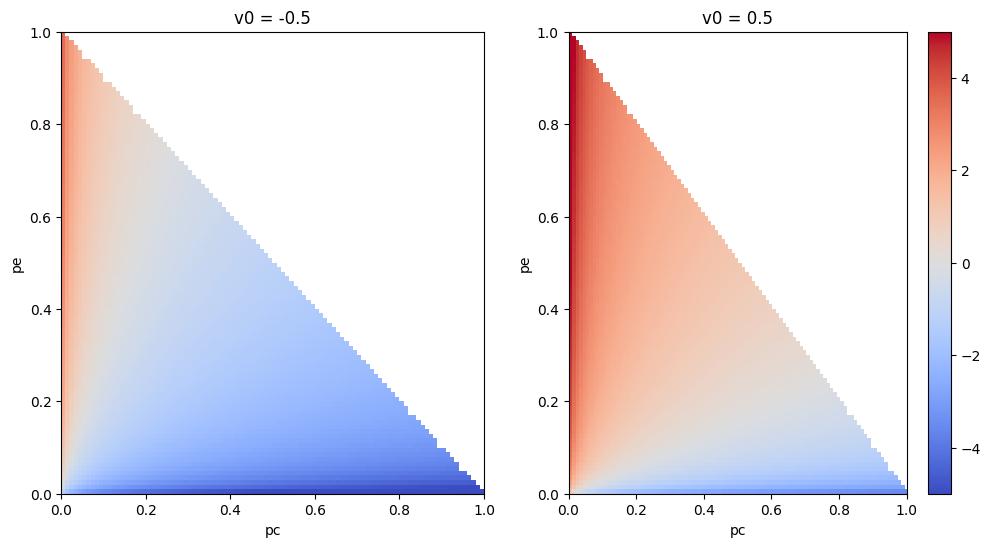

In [29]:
def llr(pe, pc, eps=0.01):
    return np.log((pe+eps)/(pc+eps))


fig, axs = plt.subplots(1,2, figsize=(12,6))

for k, v0 in enumerate([-0.5, 0.5]):
    pe_vals = np.linspace(0, 1, 100)
    pc_vals = np.linspace(0, 1, 100)
    llr_grid = np.zeros((len(pe_vals), len(pc_vals)))
    
    p0 = (v0+1)/2
    l0 = np.log(p0 / (1-p0))

    for i, pe in enumerate(pe_vals):
        for j, pc in enumerate(pc_vals):
            if pe + pc > 1:
                llr_grid[i,j] = np.nan
            else:
                llr_grid[i, j] = l0 + llr(pe, pc, eps)

    ax = axs[k]
    im = ax.imshow(
        llr_grid, extent=[0, 1, 0, 1], origin='lower', 
        aspect='auto', cmap='coolwarm', 
        vmin=-5, vmax=5
    )
    ax.set_title(f"v0 = {v0}")
    ax.set_xlabel("pc")
    ax.set_ylabel("pe")

plt.colorbar(im)
plt.show()

In [28]:
v0 = -0.5
p0 = (v0+1)/2
l0 = np.log(p0 / (1-p0))

print(l0)
print(llr(0.1, 0.9))
print(l0 + llr(0.1, 0.9))

-1.0986122886681098
-2.1129642337184795
-3.211576522386589


In [45]:
state = ConversationState(
    messages=[scenario["prompt"]],
    agents=scenario["personas"]["names"],
)

print(f"\033[93m{agents[0].name}:\033[0m {scenario['prompt']}")

ers = []
ers2 = []
ers3 = []
ers4 = []
rwps = []
rnps = []

ent_reward = nli_model.get_embed_and_prob(
    premise=scenario["prompt"], hypothesis=hypothesis) 
    
ent_reward2 = ent_reward

t = f"{agents[0].persona}\n {scenario['prompt']}"
ent_reward3 = nli_model.get_embed_and_prob(
    premise=t, hypothesis=hypothesis
)

ent_reward4 = ent_reward3

rating_with_persona = agents[0].interview(
    state, hypothesis=hypothesis, use_persona=True)

rating_no_persona = agents[0].interview(
    state, hypothesis=hypothesis, use_persona=False)

ers.append(ent_reward[1])
ers2.append(ent_reward2[1])
ers3.append(ent_reward3[1])
ers4.append(ent_reward4[1])
rwps.append(rating_with_persona)
rnps.append(rating_no_persona)

# run full conversation
for turn in range(3):

    for a in [1,0]:
    
        response = agents[a].get_response(
            state, 
            lever=levers[LEVER] if a==1 else None,
            temperature=0.7,
        )

        state = state.add_message(response)

        ent_reward = nli_model.get_embed_and_prob(
            premise=response, hypothesis=hypothesis) 
        
        ent_reward2 = nli_model.get_embed_and_prob(
            premise="\n".join(state.get_messages_from_agent(agent=a)), 
            hypothesis=hypothesis)
        
        # t = f"{agents[a].persona}\n {response}"
        t = f"{scenario["personas"]["stance"][f"{valences[a]:.2f}"]} {response}"
        ent_reward3 = nli_model.get_embed_and_prob(
            premise=t, hypothesis=hypothesis
        )

        # t = f"{agents[a].persona}\n {"\n".join(state.get_messages_from_agent(agent=a))}"
        t = (
            f"{scenario["personas"]["stance"][f"{valences[a]:.2f}"]} "
            f"{"\n".join(state.get_messages_from_agent(agent=a))}"
        )
        ent_reward4 = nli_model.get_embed_and_prob(
            premise=t, hypothesis=hypothesis
        )
        
        rating_with_persona = agents[a].interview(
            state, hypothesis=hypothesis, use_persona=True)
        
        rating_no_persona = agents[a].interview(
            state, hypothesis=hypothesis, use_persona=False)
        
        ers.append(ent_reward[1])
        ers2.append(ent_reward2[1])
        ers3.append(ent_reward3[1])
        ers4.append(ent_reward4[1])
        rwps.append(rating_with_persona)
        rnps.append(rating_no_persona)

        print(
            f"\033[93m{agents[a].name}:\033[0m {response}"
            # f"\033[90m({er[0]:.2f}, {er[1]:.2f}, {er[2]:.2f}) "
            # f"({er2[0]:.2f}, {er2[1]:.2f}, {er2[2]:.2f})\033[0m\n"
        )

ers = torch.stack(ers).numpy()
ers2 = torch.stack(ers2).numpy()
ers3 = torch.stack(ers3).numpy()
ers4 = torch.stack(ers4).numpy()
rwps = np.array(rwps)
rnps = np.array(rnps)



Jim: I'm in the market for a new guitar, any suggestions?
Rob: I've been playing Fender guitars for years, and I can honestly say they're the most versatile and responsive instruments on the market - from a Stratocaster's chime to a Telecaster's twang, there's just something about that classic Fender tone that never gets old. Plus, their quality control is unparalleled, so you know you're getting a reliable instrument that will last for decades to come. I've tried other brands and can confidently say that Fender's the only one that truly understands what makes a great guitar.
Jim: I appreciate your enthusiasm for Fender guitars, Rob, but I've had some inconsistent experiences with their humbucking pickups, which can sometimes sound muddy to me. I'm really looking for a guitar that can handle a wide range of genres and styles without sacrificing tone clarity. Have you played any guitars from other brands that might scratch that itch?
Rob: I understand where you're coming from with your 

In [84]:
embed, proba = nli_model.get_embed_and_prob(
    # premise="\n".join([state.messages[i] for i in [2]]),
    premise=(
        f"{scenario["personas"]["stance"]["-0.25"]} "
        f"{"\n".join([state.messages[i] for i in [0, 2]])}"
    ),
    # premise=state.messages[2],
    hypothesis="I like Fender products and would be willing to buy from their brand.",
    # hypothesis=hypothesis,
)
proba = proba.numpy()
print([f"{p:.3f}" for p in proba])

['0.252', '0.746', '0.003']


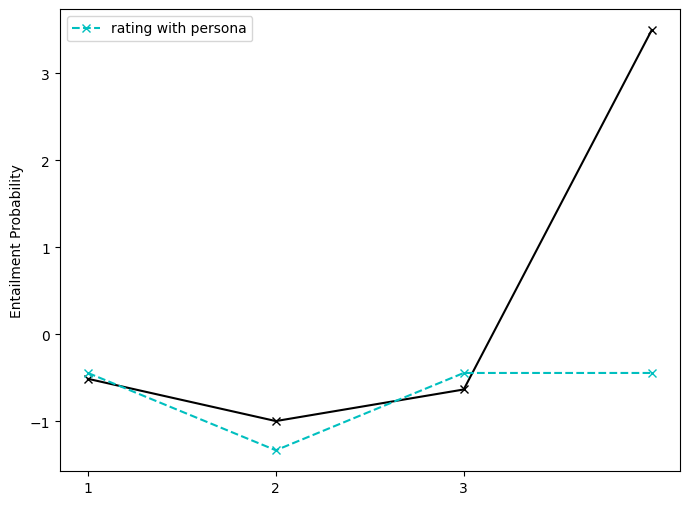

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# def rescale(x):
#     return (2 * (x - 1) / (10 - 1)) - 1

def rescale(x):
    return (x - 1) * (8 / 9) - 4

def llr(pe, pc, eps=0.01):
    return np.log((pe+eps) / (pc+eps))

# ax.plot(range(4), ers[::2, 0] - ers[::2, 2], "ko-", label="last message")
# ax.plot(range(4), ers2[::2, 0] - ers2[::2, 2], "co-", label="context + last message")
# ax.plot(range(4), ers3[::2, 0] - ers3[::2, 2], "kx-", label="persona + last message")
# ax.plot(range(4), ers4[::2, 0] - ers4[::2, 2], "cx-", label="persona + context + last message")

# ax.plot(range(4), llr(ers[::2,0], ers[::2,2]), "ko-")
p0 = (v0+1)/2
ax.plot(range(4), np.log(p0/(1-p0)) + llr(ers2[::2,0], ers[::2,2]), "kx-")

ax.plot(range(4), rescale(rwps[::2]), "cx--", label="rating with persona")
# ax.plot(range(4), rescale(rnps[::2]), "co--", label="rating no persona")

ax.set_xticks(range(3))
ax.set_xticklabels([f"{i+1}" for i in range(3)])
ax.set_ylabel("Entailment Probability")
ax.legend()

In [39]:
rescale(1)

np.float64(0.7310585786300049)

In [48]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

sigmoid(4)

np.float64(0.9820137900379085)

In [61]:
[[f"{p:.2f}" for p in t] for t in ers2[::2,:]]

[['0.00', '1.00', '0.00'],
 ['1.00', '0.00', '0.00'],
 ['1.00', '0.00', '0.00'],
 ['1.00', '0.00', '0.00']]

In [14]:
np.log(0.26/0.06)

np.float64(1.4663370687934272)

In [15]:
np.log(1)

np.float64(0.0)